In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from scipy.special import erf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# faz a leitura do ficheiro de dados localizado no github

url = 'https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv'
df = pd.read_csv(url,error_bad_lines=False)
#df = df.fillna(value=0)



In [3]:
# define as funções utilizadas nos modelos

def logistic_model(x,a,b,c):
    return c/(np.exp((b-x)/a)+1)

def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def log_logistic_model(x,a,b,c):
    return c/(1+np.power((x/a),-b))

def error_function_model(x,a,b,c,d):
    return a*(1+erf((x-b)/c))-d






In [4]:
x_all = list(df.index)
y_all = list(df['obitos'])

n = 100

x = x_all[n:]
y = y_all[n:]


#print(x,y)

In [5]:
# utiliza curve_fit para fazer o ajuste dos dados, calculando os parâmetros a,b,c

logistic_fit = curve_fit(logistic_model,x,y,p0=[1,10,2000])

param_a_logistic = logistic_fit[0][0]
param_b_logistic = logistic_fit[0][1]
param_c_logistic = logistic_fit[0][2]
 
print("Logistic model: a = % 5.2f; b = % 5.2f; c = % 5.2f" %(param_a_logistic, param_b_logistic, param_c_logistic))    

log_logistic_fit = curve_fit(log_logistic_model,x,y,p0=[65,3,2000],bounds=(0, [9999., 9999., 9999.]))

param_a_log_logistic = log_logistic_fit[0][0]
param_b_log_logistic = log_logistic_fit[0][1]
param_c_log_logistic = log_logistic_fit[0][2]

print("Log-Logistic model: a = % 5.2f; b = % 5.2f; c = % 5.2f" %(param_a_log_logistic, param_b_log_logistic, param_c_log_logistic))

erf_fit = curve_fit(error_function_model,x,y,p0=[1,1,1,1])

param_a_erf = erf_fit[0][0]
param_b_erf = erf_fit[0][1]
param_c_erf = erf_fit[0][2]
param_d_erf = erf_fit[0][3]

print("Error function model: a = % 5.2f; b = % 5.2f; c = % 5.2f; d = % 5.2f" %(param_a_erf, param_b_erf, param_c_erf, param_d_erf))




Logistic model: a =  1.00; b =  10.00; c =  2051.21
Log-Logistic model: a =  575.57; b =  1.20; c =  9999.00
Error function model: a =  336.31; b =  1.00; c =  1.00; d = -1378.59


C:\Users\OMEN\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [6]:
# calcula o erro associado ao ajuste efetuado 

errors_logistic = [np.sqrt(logistic_fit[1][i][i]) for i in [0,1,2]]
print(errors_logistic)

y_pred_logistic = [logistic_model(i,param_a_logistic,param_b_logistic,param_c_logistic) for i in x]

errors_log_logistic = [np.sqrt(log_logistic_fit[1][i][i]) for i in [0,1,2]]

y_pred_log_logistic = [log_logistic_model(i,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic) for i in x]

errors_erf = [np.sqrt(erf_fit[1][i][i]) for i in [0,1,2,3]]

y_pred_erf = [error_function_model(i,param_a_erf,param_b_erf,param_c_erf,param_d_erf) for i in x]


[inf, inf, inf]


In [7]:
# calcula a data final da infeção resolvendo a equação associada ao modelo

sol_logistic = int(fsolve(lambda x : logistic_model(x,param_a_logistic,param_b_logistic,param_c_logistic) - int(param_c_logistic),param_b_logistic))
end_date_logistic = datetime(2020, 1, 1) + timedelta(days=sol_logistic)


                              

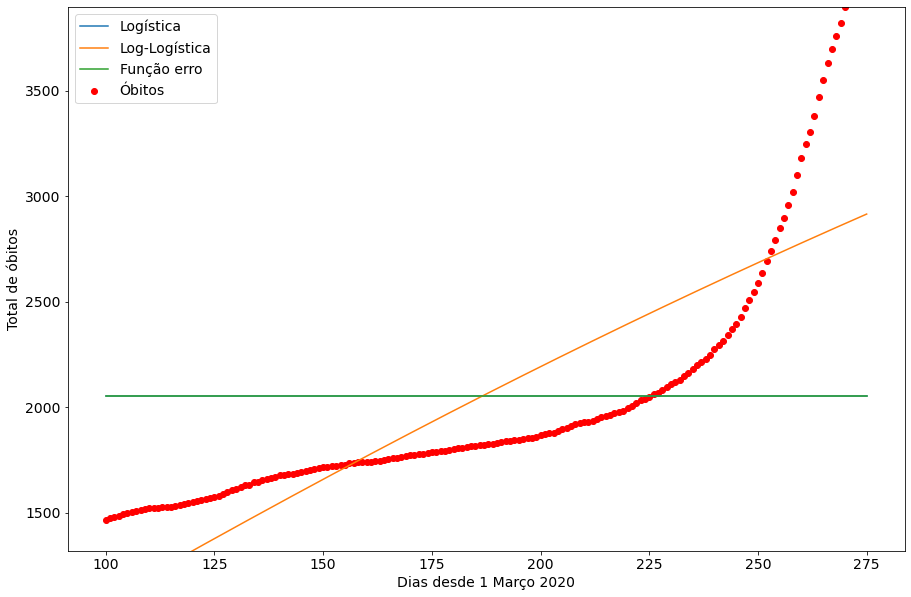

Previsão de óbitos a uma semana: 2051 (modelo logístico)
Previsão de óbitos a uma semana: 2987 (modelo log-logístico)
Previsão de óbitos a uma semana: 2051 (modelo função erro)
* * * * * * * * * * * * * * * * 
Erro quadrado médio do ajuste: 394574 (modelo logístico)
Erro quadrado médio do ajuste: 139180 (modelo log-logístico)
Erro quadrado médio do ajuste: 394574 (modelo função erro)


In [8]:
# constrói o gráfico e mostra os resultados das predições

pred_x = list(range(max(x),sol_logistic))

plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', size=14)

# Real data
plt.scatter(x,y,label="Óbitos",color="red")

# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,param_a_logistic,param_b_logistic,param_c_logistic) for i in x+pred_x], label="Logística" )

# Predicted log-logistic curve
plt.plot(x+pred_x, [log_logistic_model(i,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic) for i in x+pred_x], label="Log-Logística" )

# Predicted error function curve
plt.plot(x+pred_x, [error_function_model(i,param_a_erf,param_b_erf,param_c_erf,param_d_erf) for i in x+pred_x], label="Função erro" )

plt.legend()
plt.xlabel("Dias desde 1 Março 2020")
plt.ylabel("Total de óbitos")
plt.ylim((min(y)*0.9,param_c_logistic*1.9))
plt.show()

# print previsões
print("Previsão de óbitos a uma semana: %d (modelo logístico)" %(logistic_model(max(x)+8,param_a_logistic,param_b_logistic,param_c_logistic)))
print("Previsão de óbitos a uma semana: %d (modelo log-logístico)" %(log_logistic_model(max(x)+8,param_a_log_logistic,param_b_log_logistic,param_c_log_logistic)))
print("Previsão de óbitos a uma semana: %d (modelo função erro)" %(error_function_model(max(x)+8,param_a_erf,param_b_erf,param_c_erf,param_d_erf)))
print("* * * * * * * * * * * * * * * * ")
print("Erro quadrado médio do ajuste: %1d (modelo logístico)" %mean_squared_error(y,y_pred_logistic))
print("Erro quadrado médio do ajuste: %1d (modelo log-logístico)" %mean_squared_error(y,y_pred_log_logistic))
print("Erro quadrado médio do ajuste: %1d (modelo função erro)" %mean_squared_error(y,y_pred_erf))
